#Actor/Critic Reinforcement Learning

This is another example of two cooperating (or competing) networks that learn at the same time.  Similar to GANs or MIAC, we learn a teacher/critic network, and use this to train the actor/controller/generator network.  Here we do this in the context of reinforcement learning.

Reinforcement learning is the situation in which the environment provides a reward (or cost) signal at some point in the future, and it is the goal of the network to figure out how to maximize this reward (or minimize the cost).  In the most general case, cost is provided at every moment in time, and the goal is to minimize the total future cost.  An important assumption (which is often necessary to make the math work) is that near-term cost is more important than long-term cost.  In other words, we worry a bit less about things that may have cost far in the future than we do about things that have cost right now.  To model this, we use the "future discounted cost"
\begin{equation}
  C = \sum_t \gamma^t c(t)
\end{equation}
where $\gamma <1$.  

The problem is generally formulated as a search for a path through state space.  In other words, for each state $x(t)\in X$ we decide which next state $x(t+1)$ we want to choose.  To move between states we have a set of "actions" that in some sense say the direction that we want to go.  The world (plant) takes a current state and a current action and tells us what the next state will be.  It also tells us the cost of moving to the next state.  So we have
\begin{equation}
  x(t+1), c(t+1) = F(x(t), u(t))
\end{equation}
where $c(t+1)$ is the instantaneous cost, and $u(t)$ is the control input.  Since the state is everything knowable about where we are, the choice of action depends only on the state, and we call this a "policy"
\begin{equation}
  u(t) = \pi (x(t))
\end{equation}
Our goal is to find a policy $\pi$ such that the future discounted cost (the "total cost-to-go") for that policy is minimized.

There are a very large number of possible policies, and a search through all of them is usually impossible.  Fortunately, the Bellman principle considerably simplifies the problem (although it is still hard).  The Bellman principle says that the optimal path forward does not depend on how you got to the current state $x(t)$.  This eliminates many possibilities, because all the ways you could have gotten to the current state collapse into the same problem.  You still have to figure out the optimal path forward, but note that after you take one more step, the optimal path forward from $x(t+1)$ no longer depends on $x(t)$.  It also means that if you know the optimal path from all possible values of $x(t+1)$ to the goal, then all you have to do is figure out which of the possible $x(t+1)$'s is on the optimal path from $x(t)$ and you can just follow the remaining path from there.  

In practice, this means that the right answer is to search from the goal, just as if you were tracing backward in a labyrinth.  For example, suppose that there is some goal state $X(T)$.  The cost to being in $x(T)$ is zero, because you have achieved your goal and there is no more cost to get there.  For each value of $x(T-1)$ that is one step away from $x(T)$, the cost might be 1, meaning this is the amount of time (cost) to get to the goal.  For each of those, you know the optimal path, which is to move to $x(T)$.  Now look at a particular value of $x(T-2)$.  It might be closer to some of the $x(T-1)$'s, and farther from others.  Because all the $x(T-1)$'s have the same cost (1), you can optimize this by moving to the closest one. The cost to do that might also be one time unit, so a transition cost of 1 to get to the closest $x(T-1)$, then another cost of 1 to get to $x(T)$ (and $x(T-1)$ knows how to do this).  So now you have a minimum cost of 2.  The cost could be more if you had decided to go to a position $x(T-1)$ that was farther away.   But that would not be a good idea.

Suppose you knew the cost-to-go for each possible next step $C[x(t+1)]$, and you also know the transition cost $R[x(t),x(t+1)]$.  Then choosing the next move is easy.  Just find the minimum of 
\begin{equation}
  R[x(t),x(t+1)] + C[x(t+1)]
\end{equation}
In fact, all you really need to know is the transition cost for each possible action, so that you choose the action $u(t)$ to minimize
\begin{equation}
  Q[x,u] = R[x(t),u(t)] + C[F[x(t),u(t)]]
\end{equation}
remembering that $C[]$ is the total future discounted cost.  

Why is this possible?  Doesn't $C$ depend on the path you take in the future?  Of course it does.  But the Bellman equation says that if it is the *optimal* path then there is only one (or at least, only one optimal total cost).  So $C[]$ is the *optimal future discounted cost-to-go*.  So Watkins Q-function is the total cost-to-go if you are in state $x$ and take action $u$ and then after that follow the optimal path until you reach the goal.  

Remember that the policy makes the control $u$ a function of $x$, so our goal is to find the policy $\pi$ such that
\begin{equation}
  \pi (x) = u = {\rm argmin~} Q[x,u]
\end{equation}
So now we get a sense of how you could use a network to figure this out.  Train a function $\hat{Q}(x,u) \approx C$.  The cost function will be something like $E[(\hat{Q} - C)^2]$.  Then use this network (the critic) to train the policy (actor) to minimize $\hat{C} = Q[x,\pi (x)]$ for every value of $x$.

The problem is, just as in MRAC/MIAC, we need to ensure persistent excitation.  In other words, if we never follow the optimal path, then $\hat{C} will not learn the optimal cost to go. Over time, the policy will improve, and as it improves the critic will see more and more optimal policies and will start to learn the optimal cost-to-go, and in return the actor will get better and better on the true data.  But except in certain specific circumstances there is usually no guarantee that you will ever find the optimal path.  Nevertheless, the system works surprisingly well.  

An alternative to learning $Q$ is to learn a *value function* $V(x)$ which gives the optimal cost to go $C$ if you happen to be at point $x$.  $V$ does not depend explicitly on the control $u$, but if $u(t)$ causes you to move from $x(t)$ to $x(t+1)$ then the transition cost is $V(t) - V(t+1)$.  The Temporal Difference learning algorithm iteratively matches $V(t) - V(t+1)$ (the "temporal difference") with the observed transition costs $R[x(t),x(t+1)]$.  Once the pattern is conssitent, then $V$ indicates the true cost at each point, and all you have to do is descend the gradiene (ie: choose the smallest value of $V$ and move in that direction.  




In [1]:
#The usual preamble
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from keras import layers
import time
import math as m
import torch

import tensorflow as tf
from scipy import signal
import tensorflow.keras.utils as ku

from numpy.random import default_rng
from numpy import linalg as LA

from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Permute, AveragePooling2D, Concatenate
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv2D, LayerNormalization, SimpleRNN
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D, ConvLSTM2D, LSTM, Input
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping

rng = default_rng()

#for your homework
np.random.seed(10327798)
tf.random.set_seed(10327798)

#Landing an Airplane

This is a very simple toy problem.  A network is in control of an airplane, and it can choose whether to fly up, down, or straight at any given time.  The goal is to land the plane along a glidepath that is diagonally downard.  The plan needs to land on the runway, and it is penalized heavily for landing before or after the runway, or for not landing at all.

The first step is to create a cost function.  There is a cost for time, otherwise the airplane could just oscillate in the air. There is also a cost for being too low or too high.  These are the transition costs, the total cost is the sum of the (future discounted) transition costs.

In [2]:
#The cost function sets the allowable locations for the glide path
nHPositions = 100
nVPositions = 50

vlow = float(nHPositions)/4.0
vhigh = float(nHPositions)/2.5
cost_function = np.ones((nVPositions, nHPositions)) # at least one in each spot, due to cost of time
for h in range(nHPositions): 
  if vlow > 0:
    cost_function[0:int(vlow), h] = 10
  if vhigh > 0:
    cost_function[int(vhigh):nVPositions, h] = 10
  else:
    cost_function[:,h] = 10
  vlow -= 0.5
  vhigh -= 0.5

cost_function[:, nHPositions-2] = 100 #off the end of the runway
cost_function[1,0:50] = 100  #land too early
cost_function[0,50:nHPositions] = 0 #the runway
#stop if go off the sides
cost_function[:,nHPositions-1] = 0
cost_function[0, :] = 0
cost_function[nVPositions-1,:] = 0

cost_function /= cost_function.max()
    


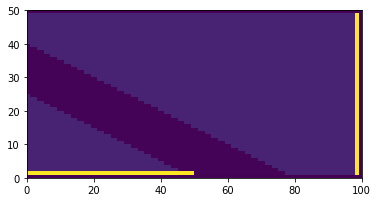

In [3]:
plt.imshow(cost_function,extent=(0,nHPositions, nVPositions,0))
plt.gca().invert_yaxis()

#The Plant

The plant takes (state,action) as input and produces (next_state, cost) as output.  It also lets us know when the plane has landed or hit an airspace boundary.

In [4]:
#The plant takes a state and an action and outputs the new state and the cost of the transition
n_state_dimensions =  2 
n_action_dimensions = 3 #one-hot encoding
n_cost_dimensions = 1

def Plant(old_state, action):
  #state is a 2D integer vector that is [horizontal_position, vertical_position].  horizontal_position = time
  #action is a one-hot command:  +1 = up(0), 0=level(1), -1 = down(2)
  a = action.dot([1.5,0,-1.5])[0]
  a = a - 0.3  #tends to fly down
  new_state = old_state + np.array([1, a]) #move to the right and go up or down or level
  new_state = np.around(new_state)  #convert to integers
  new_state = new_state.astype(int)
  for k in range(2):
    if new_state[0][k] >= nVPositions:
      new_state[0][k] = nVPositions -1
    if new_state[0][k] < 0:
      new_state[0][k] = 0
  transition_cost = cost_function[new_state[0][1], new_state[0][0]]
  if transition_cost == 0:
    is_end_state = True
  else:
    is_end_state = False
  return (new_state, transition_cost, is_end_state)

#The Policy

We will implement the policy $u=\pi (x)$ as a trainable network.  The command output will be a 3-element softmax, although it seems likely that the network would use all 3 elements, possibly in a more linear fashion.  But at least this restricts the output to be between +/- 1, rather than allowing the plane to dive or climb unreasonably.

In [5]:
#Policy: state -> action
n_policy_inputs = n_state_dimensions   
n_policy_outputs = n_action_dimensions   #one-hot action up,level, down

def make_policy_model(n_policy_inputs):
    model = tf.keras.Sequential()
    model.add(layers.Input(shape=(n_policy_inputs,)))
    model.add(layers.Rescaling(1./100))
    model.add(layers.Dense(80,  activation='relu'))
    model.add(layers.Dense(40, activation='relu'))
    model.add(layers.Dense(40, activation='relu'))
    model.add(layers.Dense(20, activation='sigmoid'))
    model.add(layers.Dense(n_policy_outputs, activation='softmax'))

    return model

Policy = make_policy_model(n_policy_inputs)

#Noise

It is important that the state space be explored so that the critic can learn as many states as possible.  This is a tradeoff between "exploration" (wandering around state space) and "exploitation" (always taking the path that, at least for the moment, seems to be optimal).  

In [6]:
def make_noise_layer(n_inputs):
  model = tf.keras.Sequential()
  model.add(layers.Input(shape = (n_inputs,)))
  model.add(layers.GaussianNoise(0.5))
  return model
Noise = make_noise_layer(n_policy_outputs)

#Cost model

This is the model that tries to predict the total cost-to-go from the current state and action.  Note that this is not the cost to the next state.  It is the full Bellman cost assuming that after the next state you do the optimal path forever.  

We use the functional API because there are two different types of input function.

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 rescaling_1 (Rescaling)        (None, 2)            0           ['input_3[0][0]']                
                                                                                                  
 input_4 (InputLayer)           [(None, 3)]          0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 5)            0           ['rescaling_1[0][0]',            
                                                                  'input_4[0][0]']            

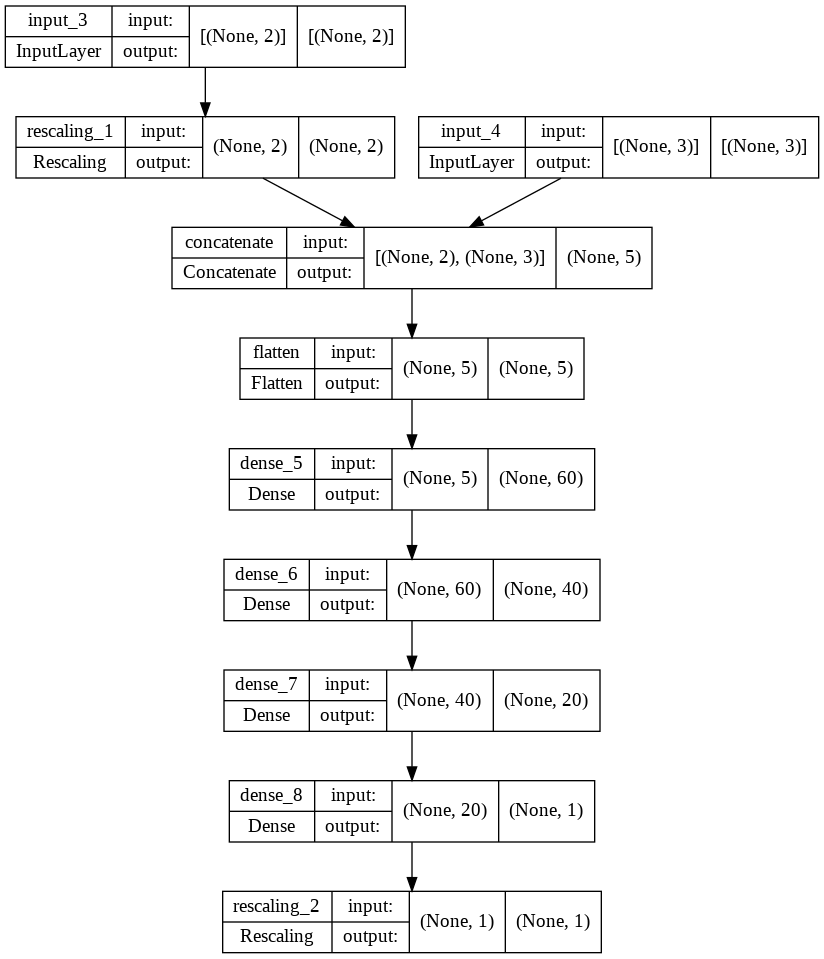

In [7]:
#Cost: state,action -> predicted_total_cost_to_go
n_fc_inputs = n_state_dimensions + n_action_dimensions
n_fc_outputs = n_cost_dimensions  #always 1; there is only 1 cost

def make_cost_model(n_state_dimensions, n_action_dimensions):
    state_input = layers.Input(shape=(n_state_dimensions,))
    state_scaled_input = layers.Rescaling(1/100.)(state_input)
    action_input = layers.Input(shape=(n_action_dimensions,))
    inputs = layers.Concatenate()([state_scaled_input,action_input])
    calc = layers.Flatten()(inputs)
    calc = layers.Dense(60, activation='relu')(calc)
    calc = layers.Dense(40, activation='relu')(calc)
    calc = layers.Dense(20, activation='relu')(calc)
    calc = layers.Dense(1, activation='linear')(calc)
    calc = layers.Rescaling(1000.)(calc)

    model = Model(inputs=[state_input,action_input],outputs=calc)

    return model
Cost = make_cost_model(n_state_dimensions, n_action_dimensions)
Cost.compile(optimizer='adam', loss='mse')
Cost.summary()
plot_model(Cost, show_shapes = True, show_layer_names = True)

In [8]:
#make sure everything works and prealloate these objects
state = np.array([[1,2]])
action = Policy(state)
action = Noise(action, training=True)
print(action)
Plant(state,action.numpy())

tf.Tensor([[0.67706203 0.03947301 0.40470535]], shape=(1, 3), dtype=float32)


(array([[2, 2]]), 0.1, False)

#Run Policy

Starting at a specified initial state $x(0)$, run the current policy until you hit the edge, and save all the states and costs.

In [9]:
#Single run of the current policy
def run_policy(initial_state):
  #initial state is a 1x2 numpy array
  state_sequence = np.empty((0,n_state_dimensions),int)  #states are integers
  action_sequence = np.empty((0,n_action_dimensions), float) #probability one-hot
  cost_sequence = np.empty((0,n_cost_dimensions), float)  #cost is a scalar
  at_end = False
  state = initial_state
  while not at_end:
    action = Policy(state)
    action = Noise(action, training=True)
    state, cost, at_end = Plant(state, action.numpy())
    #save all the values for training
    state_sequence = np.vstack([state_sequence, state])
    action_sequence = np.vstack([action_sequence,action])
    cost_sequence = np.vstack([cost_sequence, cost])


  return state_sequence, action_sequence, cost_sequence

#Cost-to-go

Calculate the value of this.  There is a discount factor so that future cost is less important.

In [10]:
def calc_cost_to_go(cost_sequence, lambda_discount):
  ctg_seq = np.zeros(cost_sequence.shape)
  ln = len(cost_sequence)-1
  ctg_seq[ln] = cost_sequence[ln]
  for n in range(ln-1,-1,-1):
    ctg_seq[n] = cost_sequence[n] + lambda_discount * ctg_seq[n+1]
  return ctg_seq

  

In [11]:
#for training the Policy
mse = tf.keras.losses.MeanSquaredError()
policy_optimizer = tf.keras.optimizers.Adam(3e-3)

#Train the policy

Note that we compute Policy(state) and Cost([state,action]) within the gradient tape, so that it knows the link between action and policy_loss.  Then it can compute the gradients with respect to the policy network and update the variables.

In [12]:
#have to do this at least once to create the variables
action = Policy(state)
estimated_cost_to_go = Cost([state,action])
policy_loss = mse(estimated_cost_to_go,0)
      
# tf.function causes the function to be "compiled".
@tf.function
def policy_train_step(state):
    with tf.GradientTape() as policy_tape:   #tapes will watch all the trainable variables
      action = Policy(state)
      policy_loss = Cost([state,action])
    
    gradients_of_policy = policy_tape.gradient(policy_loss, Policy.trainable_variables)  #find the gradients based on the relative changes in the variables
    policy_optimizer.apply_gradients(zip(gradients_of_policy, Policy.trainable_variables))  #gradient descent on the weights

##The training loop!

Time for epoch 1 is 7.0625410079956055 sec
Time for epoch 11 is 0.3657047748565674 sec
Time for epoch 21 is 0.21562933921813965 sec
Time for epoch 31 is 0.5054292678833008 sec
Time for epoch 41 is 0.2931396961212158 sec
Time for epoch 51 is 0.782372236251831 sec
Time for epoch 61 is 0.3979346752166748 sec
Time for epoch 71 is 0.23481106758117676 sec
Time for epoch 81 is 0.3081505298614502 sec
Time for epoch 91 is 0.23137569427490234 sec
Time for epoch 101 is 0.22408127784729004 sec
Time for epoch 111 is 0.190887451171875 sec
Time for epoch 121 is 0.2732837200164795 sec
Time for epoch 131 is 0.36902308464050293 sec
Time for epoch 141 is 0.27754807472229004 sec
Time for epoch 151 is 0.2886471748352051 sec
Time for epoch 161 is 0.11586952209472656 sec
Time for epoch 171 is 0.11284518241882324 sec
Time for epoch 181 is 0.32472944259643555 sec
Time for epoch 191 is 0.2487800121307373 sec
Time for epoch 201 is 0.18656635284423828 sec
Time for epoch 211 is 0.13329362869262695 sec
Time for epo

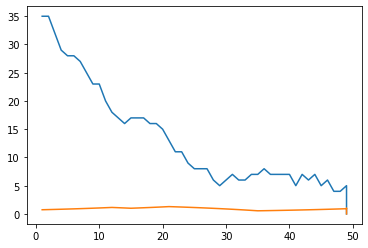

In [13]:
for epoch in range(400):
  start = time.time()

  initial_state = np.array([[0,rng.integers(5, 45)]])
  state_seq, action_seq, cost_seq = run_policy(initial_state)
  cost_to_go = calc_cost_to_go(cost_seq, 0.95)

  #can just use regular fitting for this.  just do once per iteration because will iterate with the policy training.
  Cost.fit([state_seq,action_seq], cost_to_go, epochs=1, verbose=0)

  for s1 in range(len(state_seq)):
    state = state_seq[s1,:]  #run through all the states on this attempt
    state_batch = torch.tensor(state_seq)
    state_batch32 = tf.cast(state_batch,tf.float32)  #tensorflow can only handle float32, but float64 is the default
    policy_train_step(state_batch32)
  
  if epoch%10 == 0:
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

plt.figure()
plt.plot(state_seq[:,0],state_seq[:,1])
plt.plot(state_seq[:,0], cost_to_go);

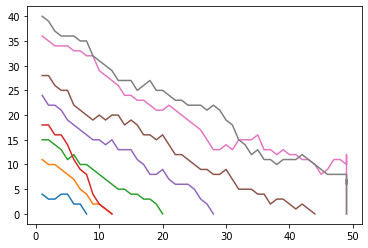

In [14]:
plt.figure()
for initial_ystate in range(5,45,5):
  initial_state = np.array([[0,initial_ystate]])
  
  state_seq, action_seq, cost_seq = run_policy(initial_state)
  cost_to_go = calc_cost_to_go(cost_seq, 0.9)
  plt.plot(state_seq[:,0],state_seq[:,1])
  #plt.plot(state_seq[:,0], cost_to_go);

In [15]:
ctg = np.zeros((nVPositions,nHPositions))
opt = np.zeros((nVPositions,nHPositions))
for h in range(nHPositions):
  for v in range(nVPositions):
    state = np.array([[h,v]])
    action = Policy(state)
    estimate_cost_to_go = Cost([state,action]).numpy()[0][0]
    ctg[v,h] = estimate_cost_to_go
    opt[v,h] = action.numpy().dot(np.array([1,0,-1]))

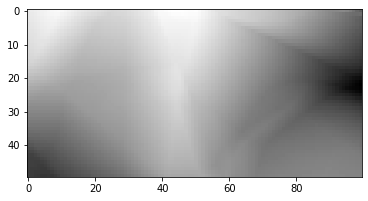

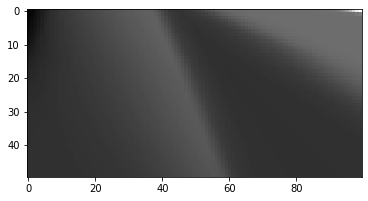

In [16]:
plt.figure()
plt.imshow(ctg, cmap='gray')
plt.figure()
plt.imshow(opt, cmap='gray');